#  导入依赖

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings

warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore")

# 定义要处理的模型(YOLOv8n目标检测模型)

In [2]:
yolo = YOLO(model='./models/yolov8-traffic.pt')
yolo = yolo.cuda()
results = yolo(source="./images/origin_img_1.jpg")
for result in results:
    print(result.boxes.cls[0])
    result.show()
results = yolo(source="./images/perturbed_img_1.jpg")
for result in results:
    print(result.boxes.cls[0])
    result.show()



image 1/1 e:\YoloCAM\images\origin_img_1.jpg: 640x640 1 P.102, 1 R.302a, 27.4ms
Speed: 87.5ms preprocess, 27.4ms inference, 64.4ms postprocess per image at shape (1, 3, 640, 640)
tensor(27., device='cuda:0')

image 1/1 e:\YoloCAM\images\perturbed_img_1.jpg: 640x640 1 P.102, 1 R.302a, 27.2ms
Speed: 2.1ms preprocess, 27.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
tensor(27., device='cuda:0')


选择要处理的层

In [3]:
yolo.info(detailed=True)
yolo_model = yolo.model
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
yolo_model = yolo_model.to(device)

layer                                    name                type  gradient  parameters               shape        mu     sigma
    0                     model.0.conv.weight              Conv2d     False        1296       [48, 3, 3, 3]   -0.0602       8.5        float32
    0                       model.0.conv.bias              Conv2d     False          48                [48]     0.688      2.38        float32
    1                             model.0.act                SiLU     False           0                  []         -         -              -
    2                     model.1.conv.weight              Conv2d     False       41472      [96, 48, 3, 3]  -0.00185    0.0721        float32
    2                       model.1.conv.bias              Conv2d     False          96                [96]      1.39      1.54        float32
    3                 model.2.cv1.conv.weight              Conv2d     False        9216      [96, 96, 1, 1]  -0.00937    0.0846        float32
    3         

In [4]:
yolo_model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0-1): 2 x Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Co

选择要进行CAM操作的目标层,暂时只检查backbone

In [5]:
yolo_nn = yolo_model.model
layer_map = {
    # 如果要选择其他c2f输出,只需要更改这个字典
    "backbone_c2f1": 2,
    "backbone_c2f2": 4,
    "backbone_c2f3": 6,
    "backbone_c2f4": 8, 
    "backbone_sppf": 9,
    "neck_c2f1": 12,
    "neck_c2f2": 15,
    "neck_c2f3": 18,
    "neck_c2f4": 21
}

layers = {layer: yolo_nn[idx] for layer, idx in layer_map.items()}

You may get an innaccurate output at first (If it's running on GPU)

可视化相关配置

In [6]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

plt.rcParams["figure.figsize"] = [3.0, 3.0]

image_path = "images/perturbed_img_2.jpg"
img = cv2.imread(filename=image_path, flags=1)
rgb_img = img.copy()[:, :, ::-1]
rgb_img = cv2.resize(src=rgb_img, dsize=(224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(img=rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(dtype=torch.float32, device=device) # type: ignore

In [7]:
def get_cam_result(
    img, model, input_tensor, chosen_layers, virtualize=True)-> np.ndarray:
    # all_layers is a dict, but target_layers must be list
    target_layers = [layers[layer_name] for layer_name in chosen_layers]
    with EigenCAM(model=model, target_layers=target_layers) as cam:
        # cam.batch_size = 1
        grayscale_cam = cam(input_tensor=input_tensor, targets=target_layers) 
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(img=img, mask=grayscale_cam, use_rgb=True)  # type: ignore
        if virtualize:
            plt.imshow(X=cam_image)
            plt.title(label=f"EigenCAM in {chosen_layers}")
            plt.show()
        return grayscale_cam

各c2f层CAM结果

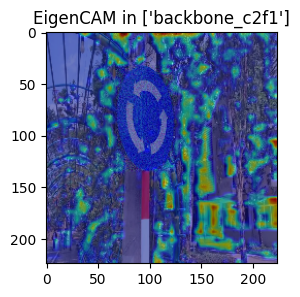

In [8]:
cam_backbone_c2f1 = get_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f1"])

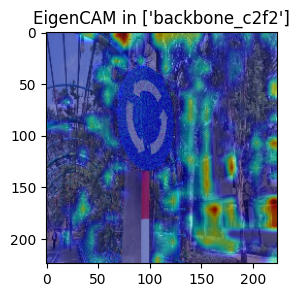

In [9]:
cam_backbone_c2f2 = get_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f2"])

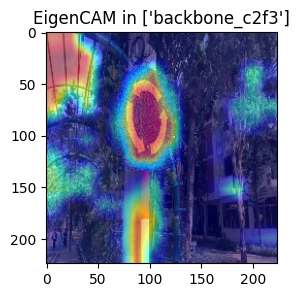

In [10]:
cam_backbone_c2f3 = get_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f3"])

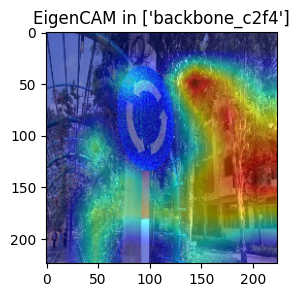

In [11]:
cam_backbone_c2f4 = get_cam_result(img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_c2f4"])

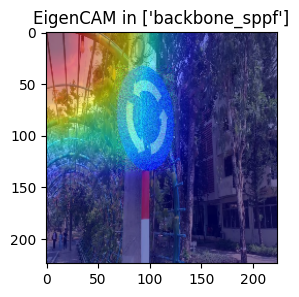

In [12]:
cam_backbone_sppf = get_cam_result(
    img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["backbone_sppf"]
)

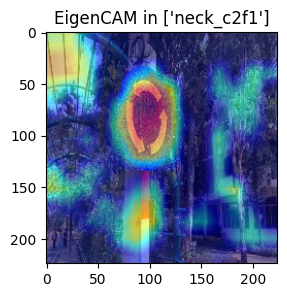

In [13]:
cam_neck_c2f1 = get_cam_result(
    img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["neck_c2f1"]
)

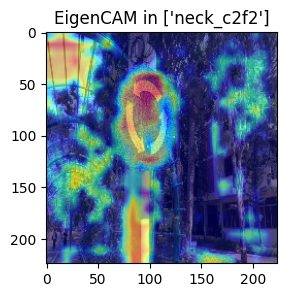

In [14]:
cam_neck_c2f2 = get_cam_result(
    img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["neck_c2f2"]
)

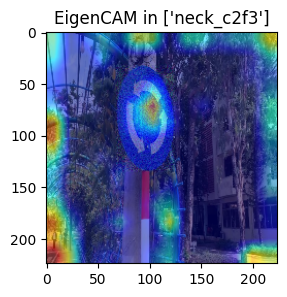

In [15]:
cam_neck_c2f3 = get_cam_result(
    img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["neck_c2f3"]
)

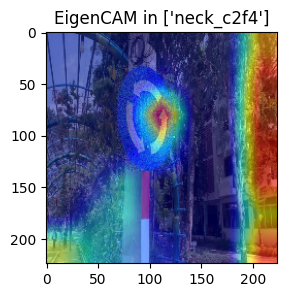

In [16]:
cam_neck_c2f4 = get_cam_result(
    img=rgb_img, model=yolo_model, input_tensor=input_tensor, chosen_layers=["neck_c2f4"]
)

**评估指标:**

**ROAD(Region Of Attention Discirmination):** (有问题:`ClassifierOutputTarget(category=17)`这一部分意义不明)

- `ROADMostRelevantFirstAverage`: 逐步移除置信度从高到地的CAM区域,比较移除前后模型预测置信度的区别,相差越大,代表高相关区域定位准确.
- `ROADLeastRelevantFirstAverage`: 逐步移除置信度从低到高的CAM区域,比较移除前后模型预测置信度的区别,相差越小,代表无关区域没有被错误定位到.

In [17]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage

def eval_ROADMostRelevantFirst(model, input_tensor, grayscale_cams, target_classes) -> None:
    cam_metric = ROADMostRelevantFirstAverage(percentiles=[20, 40, 60, 80])
    # all_layers is a dict, but target_layers must be list

    scores = cam_metric(
        model=model, input_tensor=input_tensor, cams=grayscale_cams, targets=target_classes,
    )
    # print(scores.size)
    score = scores.sum()
    print(f"The average confidence increase with ROAD accross 4 thresholds: {score}")


# You can also average across different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2

batch_cam_backbone_c2f1 = torch.from_numpy(cam_backbone_c2f1).unsqueeze(dim=0)

eval_ROADMostRelevantFirst(
    model=yolo.model, input_tensor=input_tensor, grayscale_cams=batch_cam_backbone_c2f1.numpy(), target_classes=[ClassifierOutputTarget(category=17)]
)

def eval_ROADLeastRelevantFirstAverage(model, input_tensor, grayscale_cams, target_classes) -> None:
    cam_metric = ROADLeastRelevantFirstAverage(percentiles=[20, 40, 60, 80])
    # all_layers is a dict, but target_layers must be list

    scores = cam_metric(
        model=model,
        input_tensor=input_tensor,
        cams=grayscale_cams,
        targets=target_classes,
    )
    # print(scores.size)
    score = scores.sum()
    print(f"The average confidence increase with ROAD accross 4 thresholds: {score}")


# You can also average across different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2

eval_ROADLeastRelevantFirstAverage(
    model=yolo.model,
    input_tensor=input_tensor,
    grayscale_cams=batch_cam_backbone_c2f1.numpy(),
    target_classes=[ClassifierOutputTarget(category=17)],
)

The average confidence increase with ROAD accross 4 thresholds: 1.2652309123950545e-05
The average confidence increase with ROAD accross 4 thresholds: 1.3558417776948772e-05


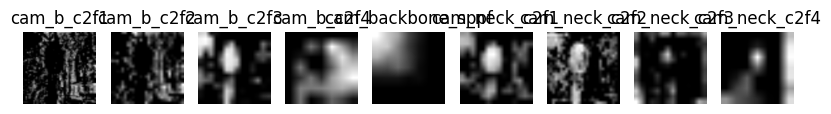

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(8, 8))

axes[0].imshow(cam_backbone_c2f1, cmap="gray")
axes[0].set_title("cam_b_c2f1")
axes[0].axis("off")
axes[1].imshow(cam_backbone_c2f2, cmap="gray")
axes[1].set_title("cam_b_c2f2")
axes[1].axis("off")
axes[2].imshow(cam_backbone_c2f3, cmap="gray")
axes[2].set_title("cam_b_c2f3")
axes[2].axis("off")
axes[3].imshow(cam_backbone_c2f4, cmap="gray")
axes[3].set_title("cam_b_c2f4")
axes[3].axis("off")
axes[4].imshow(cam_backbone_sppf, cmap="gray")
axes[4].set_title("cam_backbone_sppf")
axes[4].axis("off")
axes[5].imshow(cam_neck_c2f1, cmap="gray")
axes[5].set_title("cam_neck_c2f1")
axes[5].axis("off")
axes[6].imshow(cam_neck_c2f2, cmap="gray")
axes[6].set_title("cam_neck_c2f2")
axes[6].axis("off")
axes[7].imshow(cam_neck_c2f3, cmap="gray")
axes[7].set_title("cam_neck_c2f3")
axes[7].axis("off")
axes[8].imshow(cam_neck_c2f4, cmap="gray")
axes[8].set_title("cam_neck_c2f4")
axes[8].axis("off")
plt.tight_layout()
plt.show()

**SSIM(Structural Similarity，结构相似性)**

通过比较原始样本和对抗样本的热力图, 衡量注意力区域是否被显著改变, SSIM 越低 → 热力图结构差异越大（攻击更有效）

In [19]:
from skimage.metrics import structural_similarity  

# im1, im2分别表示参与计算的图像数据
# data_range表示图像数据的范围，一般设置为255或者1(如果对图像数据做了归一化操作，则为1)
# channel_axis表示颜色通道位于图像的第几维度，如果不指定的话，则默认输入灰度图像
ssim = structural_similarity(
    cam_backbone_c2f1,
    cam_backbone_c2f4,
    win_size=None,
    gradient=False,
    data_range=1,
    channel_axis=None,
    multichannel=False,
    gaussian_weights=False,
    full=False,
)

print(f"SSIM of cam_backbone_c2f1 & cam_backbone_c2f2: {ssim}")

SSIM of cam_backbone_c2f1 & cam_backbone_c2f2: 0.14202142638283455


**在masked_pgd对抗攻击上测试**

In [20]:
yolo_traffic = YOLO(model='./models/yolov8-traffic.pt')
yolo_traffic = yolo_traffic.cuda()
yolo_traffic_model = yolo_traffic.model.to(device)
yolo_traffic_nn = yolo_traffic_model.model
layers = {layer: yolo_traffic_nn[idx] for layer, idx in layer_map.items()}

In [21]:
origin_img = cv2.imread(filename="./images/origin_img_2.jpg", flags=1)
rgb_origin_img = origin_img.copy()[:, :, ::-1]
rgb_origin_img = cv2.resize(src=rgb_origin_img, dsize=(224, 224))
rgb_origin_img = np.float32(rgb_origin_img) / 255
input_tensor_origin_img = preprocess_image(img=rgb_origin_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(dtype=torch.float32, device=device)  # type: ignore
perturbed_img = cv2.imread(filename="./images/perturbed_img_2.jpg", flags=1)
rgb_perturbed_img = perturbed_img.copy()[:, :, ::-1]
rgb_perturbed_img = cv2.resize(src=rgb_perturbed_img, dsize=(224, 224))
rgb_perturbed_img = np.float32(rgb_perturbed_img) / 255
input_tensor_perturbed_img = preprocess_image(img=rgb_perturbed_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(dtype=torch.float32, device=device)  # type: ignore

In [22]:
cams_origin_img = {
    layer: get_cam_result(
        img=rgb_origin_img,
        model=yolo_traffic_model,
        input_tensor=input_tensor_origin_img,
        chosen_layers=[layer],
        virtualize=False,
    )
    for layer in layer_map.keys()
}

cams_perturbed_img = {
    layer: get_cam_result(
        img=rgb_perturbed_img,
        model=yolo_traffic_model,
        input_tensor=input_tensor_perturbed_img,
        chosen_layers=[layer],
        virtualize=False,
    )
    for layer in layer_map.keys()
}

SSIM of cam_origin_img and cam_perturbed_img: 
backbone_c2f1: 0.9636343326863902
backbone_c2f2: 0.9781642958550689
backbone_c2f3: 0.9551331287842689
backbone_c2f4: 0.9047849218385144
backbone_sppf: 0.036879426969998984
neck_c2f1: 0.8844158753992417
neck_c2f2: 0.8037270538466107
neck_c2f3: 0.5478848147437752
neck_c2f4: 0.957862519667803


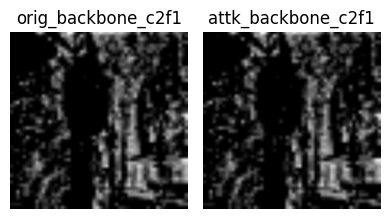

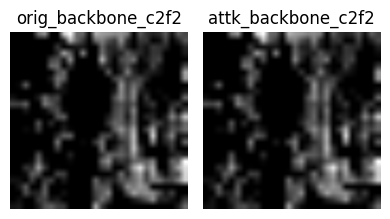

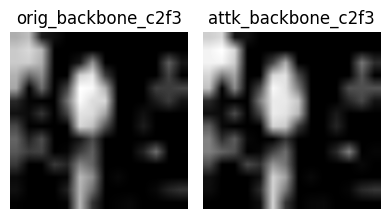

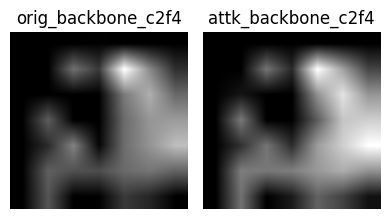

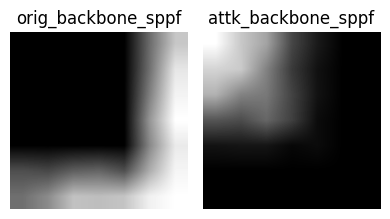

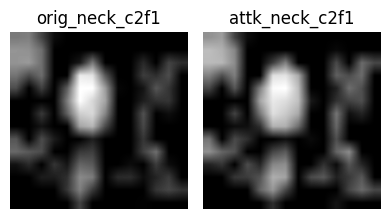

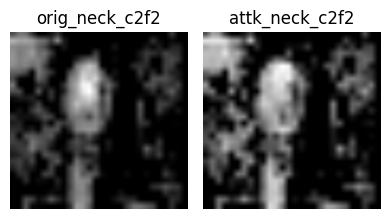

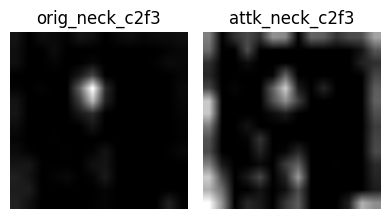

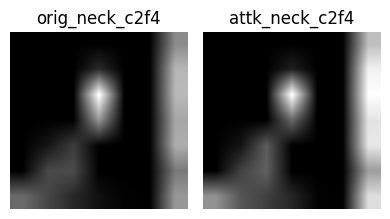

In [23]:
print("SSIM of cam_origin_img and cam_perturbed_img: ")
for chosen_layer in layer_map.keys():
    # chosen_layer = "backbone_c2f4"  # 在这里选择要比较的层次
    cam_origin_img = cams_origin_img[chosen_layer]
    cam_perturbed_img = cams_perturbed_img[chosen_layer]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 4))
    axes[0].imshow(cam_origin_img, cmap="gray")
    axes[0].set_title(f"orig_{chosen_layer}")
    axes[0].axis("off")
    axes[1].imshow(cam_perturbed_img, cmap="gray")
    axes[1].set_title(f"attk_{chosen_layer}")
    axes[1].axis("off")
    fig.tight_layout()

    fig.show()

    ssim = structural_similarity(cam_origin_img, cam_perturbed_img, data_range=1)
    print(f"{chosen_layer}: {ssim}")
    
# layer_map = {
#     # 如果要选择其他c2f输出,只需要更改这个字典
#     "backbone_c2f1": 2,
#     "backbone_c2f2": 4,
#     "backbone_c2f3": 6,
#     "backbone_c2f4": 8, 
#     "backbone_sppf": 9,
#     "neck_c2f1": 12,
#     "neck_c2f2": 15,
#     "neck_c2f3": 18,
#     "neck_c2f4": 21
# }

# S
# SSIM of cam_origin_img and cam_perturbed_img: 
# backbone_c2f1: 0.9997942613480257
# backbone_c2f2: 0.9988800610291236
# backbone_c2f3: 0.9993543305044151
# backbone_c2f4: 0.9972734578256705
# backbone_sppf: 0.9987707076693472
# neck_c2f1: 0.9793938244919129
# neck_c2f2: 0.9689466165305084
# neck_c2f3: 0.9822124863635567
# neck_c2f4: 0.986672852255135

# L
# SSIM of cam_origin_img and cam_perturbed_img: 
# backbone_c2f1: 0.9636343326863902
# backbone_c2f2: 0.9781642958550689
# backbone_c2f3: 0.9551331287842689
# backbone_c2f4: 0.9047849218385144
# backbone_sppf: 0.036879426969998984
# neck_c2f1: 0.8844158753992417
# neck_c2f2: 0.8037270538466107
# neck_c2f3: 0.5478848147437752
# neck_c2f4: 0.957862519667803

选择中等大小目标的任务上的neck_c2f3卷积层进行逐层细化分析

In [ ]:
# 加载YOLO模型（以v8为例）
neck_c2f3_nn = yolo_traffic_nn[layer_map['neck_c2f3']]
# print(neck_c2f3_nn)
# 存储特征图的字典
features = {}

# 定义钩子函数：保存当前层输出
def hook_fn(module, input, output) -> None:
    features[module.__repr__()] = output  # 或自定义唯一标识

# 遍历c2f中的所有子模块
def register_hooks(module) -> None:
    for name, child in module.named_children():
        if isinstance(child, torch.nn.Conv2d):  # 筛选卷积层
            print(child.type)
            child.register_forward_hook(hook=hook_fn)
        else:
            register_hooks(module=child)
        
register_hooks(module=neck_c2f3_nn)
        
# 输入测试数据触发前向传播
output = yolo(source='./images/perturbed_img_2.jpg')
# 提取特征图（features字典中保存了各卷积层的输出）
print(features.keys())  # 查看捕获的卷积层特征

<bound method Module.type of Conv2d(576, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)>
<bound method Module.type of Conv2d(768, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)>
<bound method Module.type of Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)>
<bound method Module.type of Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)>
<bound method Module.type of Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)>
<bound method Module.type of Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)>

image 1/1 e:\YoloCAM\images\perturbed_img_2.jpg: 640x640 2 DP.135s, 2 P.103bs, 241.9ms
Speed: 99.0ms preprocess, 241.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)
dict_keys([])
